# Regularização

## Preâmbulo

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython.display import display
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import time
import numpy as np
import numpy.random as nr
import pandas as pd
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import keras.regularizers as regul

np.set_printoptions(precision=3, linewidth=100, suppress=True)

Using TensorFlow backend.


In [2]:
nr.seed(20170521)

data = np.load('../data/boston_housing.npz')
Xtra, ytra = data['Xtra'], data['ytra']
Xval, yval = data['Xval'], data['yval']
M, N = Xtra.shape

In [3]:
layer_sizes = [N, 40, 1]
n_epochs = 2000
batch_size = M
lr = 0.05

## Regularização L1 e L2

Vamos criar três redes para comparar a regularização L1 e L2.

In [4]:
def build(l1=0.0, l2=0.0):
    n0, n1, n2 = N, 40, 1
    model = Sequential()
    if l1 > 0:
        model.add(Dense(n1, activation='sigmoid', input_dim=n0, kernel_regularizer=regul.l1(l1)))
        model.add(Dense(n2, activation='linear', kernel_regularizer=regul.l1(l1)))
    elif l2 > 0:
        model.add(Dense(n1, activation='sigmoid', input_dim=n0, kernel_regularizer=regul.l2(l2)))
        model.add(Dense(n2, activation='linear', kernel_regularizer=regul.l2(l2)))
    else:
        model.add(Dense(n1, activation='sigmoid', input_dim=n0))
        model.add(Dense(n2, activation='linear'))
    return model

In [5]:
l1 = 0.08
l2 = 0.05

# All networks are initialized with the same random weights
nn_a = build()
wts = nn_a.get_weights()
nn_b = build(l2=l2)
nn_b.set_weights(wts)      
nn_c = build(l1=l1)
nn_c.set_weights(wts)

nn_a.summary()
nn_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                520       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 40)                520       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [6]:
loss = 'mse'

opt = SGD(lr=lr)
nn_a.compile(loss=loss, optimizer=opt)
nn_b.compile(loss=loss, optimizer=opt)
nn_c.compile(loss=loss, optimizer=opt)

try:
    t0 = time.time()
    histo_a = nn_a.fit(Xtra, ytra, batch_size=batch_size, epochs=n_epochs, verbose=0, shuffle=False,
                         validation_data=(Xval, yval), callbacks=[])
    histo_b = nn_b.fit(Xtra, ytra, batch_size=batch_size, epochs=n_epochs, verbose=0, shuffle=False,
                         validation_data=(Xval, yval), callbacks=[])
    histo_c = nn_c.fit(Xtra, ytra, batch_size=batch_size, epochs=n_epochs, verbose=0, shuffle=False,
                         validation_data=(Xval, yval), callbacks=[])
    t1 = time.time()
except KeyboardInterrupt:
    pass

print('Trained in {:2f}s\n'.format(t1-t0))

Trained in 8.918249s



MSE:  13.519  for no regulariz.
MSE:  18.751  for L2 regulariz.
MSE:  17.626  for L1 regulariz.


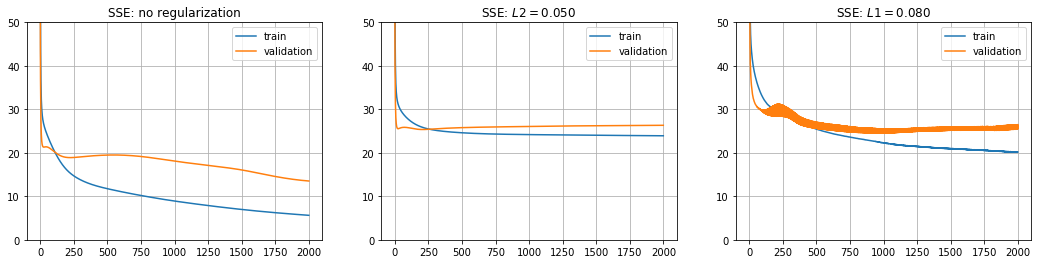

In [7]:
mse_a = np.square(nn_a.predict(Xval, verbose=0) - yval).mean()
mse_b = np.square(nn_b.predict(Xval, verbose=0) - yval).mean()
mse_c = np.square(nn_c.predict(Xval, verbose=0) - yval).mean()

print('MSE: {:7.3f}  for no regulariz.'.format(mse_a))
print('MSE: {:7.3f}  for L2 regulariz.'.format(mse_b))
print('MSE: {:7.3f}  for L1 regulariz.'.format(mse_c))

fig = plot.figure(figsize=(18,4))

fig.add_subplot(131)
plot.plot(histo_a.history['loss'], label='train')
plot.plot(histo_a.history['val_loss'], label='validation')
plot.ylim(0, 50.)
plot.legend()
plot.grid()
plot.title('SSE: no regularization');

fig.add_subplot(132)
plot.plot(histo_b.history['loss'], label='train')
plot.plot(histo_b.history['val_loss'], label='validation')
plot.ylim(0, 50.)
plot.legend()
plot.grid()
plot.title('SSE: $L2 = {:.3f}$'.format(l2));

fig.add_subplot(133)
plot.plot(histo_c.history['loss'], label='train')
plot.plot(histo_c.history['val_loss'], label='validation')
plot.ylim(0, 50.)
plot.legend()
plot.grid()
plot.title('SSE: $L1 = {:.3f}$'.format(l1));

No regularization: 0.126 +/- 1.393
L2 regularization: 0.097 +/- 0.531
L1 regularization: 0.101 +/- 1.044


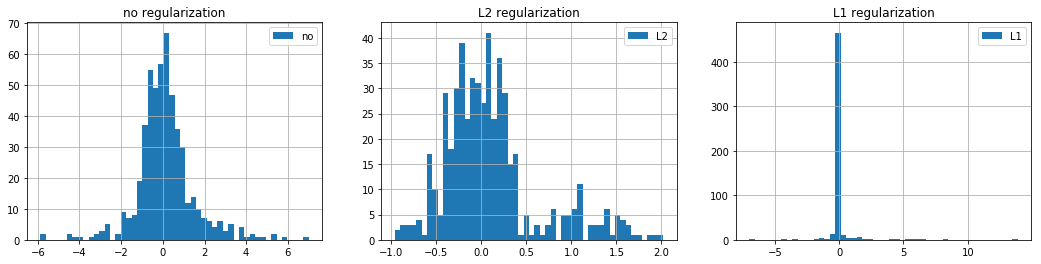

In [8]:
wa = np.concatenate([t.flat for t in nn_a.get_weights()[::2]])
wb = np.concatenate([t.flat for t in nn_b.get_weights()[::2]])
wc = np.concatenate([t.flat for t in nn_c.get_weights()[::2]])

print('No regularization: {:.3f} +/- {:.3f}'.format(wa.mean(), wa.std()))
print('L2 regularization: {:.3f} +/- {:.3f}'.format(wb.mean(), wb.std()))
print('L1 regularization: {:.3f} +/- {:.3f}'.format(wc.mean(), wc.std()))

fig = plot.figure(figsize=(18,4))

bins = 50
fig.add_subplot(131)
plot.hist(wa, bins=bins, label='no');
plot.legend()
plot.title('no regularization')
plot.grid()

fig.add_subplot(132)
plot.hist(wb, bins=bins, label='L2');
plot.legend()
plot.title('L2 regularization')
plot.grid()

fig.add_subplot(133)
plot.hist(wc, bins=bins, label='L1');
plot.legend()
plot.title('L1 regularization')
plot.grid()
# plot.ylim(0, 70)

## Early Stopping

In [9]:
model_fn = '../../models/nnet_bh.hdf5'
patience = 100

estop = EarlyStopping(patience=patience, verbose=1)
mchk = ModelCheckpoint(model_fn, save_best_only=True)

nnet = build()
nnet.set_weights(wts)      
nnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 40)                520       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [10]:
opt = SGD(lr=lr)
nnet.compile(loss='mse', optimizer=opt)

try:
    t0 = time.time()
    histo = nnet.fit(Xtra, ytra, batch_size=batch_size, epochs=n_epochs, verbose=0, shuffle=False,
                     validation_data=(Xval, yval), callbacks=[estop, mchk])
    t1 = time.time()
except KeyboardInterrupt:
    pass

print('Trained in {:2f}s\n'.format(t1-t0))

Epoch 01726: early stopping
Trained in 14.270581s



MSE (last): 16.033
MSE (best): 16.002


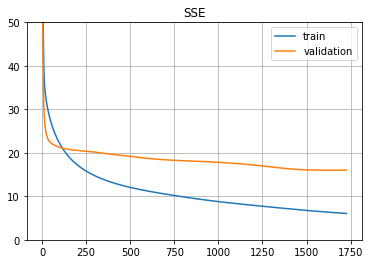

In [11]:
mse_a = np.square(nnet.predict(Xval, verbose=0) - yval).mean()
print('MSE (last): {:6.3f}'.format(mse_a))

plot.plot(histo.history['loss'], label='train')
plot.plot(histo.history['val_loss'], label='validation')
plot.ylim(0, 50.)
plot.legend()
plot.grid()
plot.title('SSE');

nnet_best = load_model(model_fn)
mse_a = np.square(nnet_best.predict(Xval, verbose=0) - yval).mean()
print('MSE (best): {:6.3f}'.format(mse_a))

## Dropout

In [12]:
def build_dropout(p=0.5):
    n0, n1, n2 = N, 40, 1
    model = Sequential()
    model.add(Dense(n1, activation='sigmoid', input_dim=n0))
    model.add(Dropout(p))
    model.add(Dense(n2, activation='linear'))
    return model

nnet = build_dropout()
nnet.set_weights(wts)      
nnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 40)                520       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 41        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [13]:
opt = SGD(lr=lr)
nnet.compile(loss='mse', optimizer=opt)

try:
    t0 = time.time()
    histo = nnet.fit(Xtra, ytra, batch_size=batch_size, epochs=n_epochs, verbose=0, shuffle=False,
                     validation_data=(Xval, yval), callbacks=[estop, mchk])
    t1 = time.time()
except KeyboardInterrupt:
    pass

print('Trained in {:2f}s\n'.format(t1-t0))

Epoch 00128: early stopping
Trained in 0.504421s



MSE: 20.510


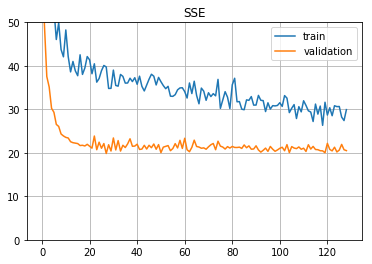

In [14]:
mse_a = np.square(nnet.predict(Xval, verbose=0) - yval).mean()
print('MSE: {:6.3f}'.format(mse_a))

plot.plot(histo.history['loss'], label='train')
plot.plot(histo.history['val_loss'], label='validation')
plot.ylim(0, 50.)
plot.legend()
plot.grid()
plot.title('SSE');


## Exercícios

- Compare os valores obtidos de MSE das redes com regularizações L1, L2, early stop e dropout

## Aprendizados neste notebook